In [2]:
import pandas as pd
import matplotlib.pyplot as plt

%config IPCompleter.greedy=True

# Data

In [3]:
item_categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
sales_train = pd.read_csv("sales_train.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

### Descriptive stats

In [4]:
def get_descriptive_stats(df):
    print("SHAPE:")
    print(df.shape)
    print("\n\n")
    print("SAMPLE:")
    print(df.head(5))
    print("\n\n")
    print("#UNIQUE:")
    print(df.nunique())
    print("\n\n")
    print("MISSING VALUES:")
    print(df.isnull().sum())
    print("\n\n")
    print("DESCRIPTIVES:")
    print(df.describe())

In [5]:
get_descriptive_stats(items)

SHAPE:
(22170, 3)



SAMPLE:
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  



#UNIQUE:
item_name           22170
item_id             22170
item_category_id       84
dtype: int64



MISSING VALUES:
item_name           0
item_id             0
item_category_id    0
dtype: int64



DESCRIPTIVES:
           item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    1

In [6]:
get_descriptive_stats(item_categories)

SHAPE:
(84, 2)



SAMPLE:
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4



#UNIQUE:
item_category_name    84
item_category_id      84
dtype: int64



MISSING VALUES:
item_category_name    0
item_category_id      0
dtype: int64



DESCRIPTIVES:
       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000


In [7]:
get_descriptive_stats(shops)

SHAPE:
(60, 2)



SAMPLE:
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4



#UNIQUE:
shop_name    60
shop_id      60
dtype: int64



MISSING VALUES:
shop_name    0
shop_id      0
dtype: int64



DESCRIPTIVES:
         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000


In [8]:
get_descriptive_stats(sales_train)

SHAPE:
(2935849, 6)



SAMPLE:
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0



#UNIQUE:
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64



MISSING VALUES:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64



DESCRIPTIVES:
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173

# Simple baseline

We first create 2 simple baselines.

In [9]:
# Simple baseline 1: compute average sales per shop+item in November 2013/2014 and average over the 2 years.
sales_train['month'] = sales_train['date'].apply(lambda x: x.split('.')[-2])
sales_train['year'] = sales_train['date'].apply(lambda x: x.split('.')[-1])
november_only = sales_train[sales_train.month=='11']

avg_grouped = november_only.groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum'})
avg_grouped['item_cnt_day'] /= 2. # number of novembers in training set

merged_with_test = test.merge(avg_grouped,on=['shop_id','item_id'],how='left').fillna(0) # if no sales predict 0

submission_file = merged_with_test.reset_index()[['ID','item_cnt_day']]
submission_file = submission_file.rename(mapper={'item_cnt_day':'item_cnt_month'},axis=1)
submission_file.to_csv("submissions/november_average.csv",index=False)

#### Score: 3.14800

In [10]:
# Simple baseline 2: compute average sales per shop+item in each month of the training period and predict the average.
all_sales = sales_train.copy()

avg_grouped = all_sales.groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum'})
avg_grouped['item_cnt_day'] /= 34. # number of months in training set

merged_with_test = test.merge(avg_grouped,on=['shop_id','item_id'],how='left').fillna(0) # if no sales predict 0

submission_file = merged_with_test.reset_index()[['ID','item_cnt_day']]
submission_file = submission_file.rename(mapper={'item_cnt_day':'item_cnt_month'},axis=1)
submission_file.to_csv("submissions/monthly_average.csv",index=False)

#### Score: 2.04648

# EDA

## Items

In [11]:
get_descriptive_stats(items)

SHAPE:
(22170, 3)



SAMPLE:
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  



#UNIQUE:
item_name           22170
item_id             22170
item_category_id       84
dtype: int64



MISSING VALUES:
item_name           0
item_id             0
item_category_id    0
dtype: int64



DESCRIPTIVES:
           item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    1

In [12]:
items['item_name'].head(10)

0            ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
1    !ABBYY FineReader 12 Professional Edition Full...
2        ***В ЛУЧАХ СЛАВЫ   (UNV)                    D
3      ***ГОЛУБАЯ ВОЛНА  (Univ)                      D
4          ***КОРОБКА (СТЕКЛО)                       D
5    ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...
6             ***УДАР ПО ВОРОТАМ (UNI)               D
7           ***УДАР ПО ВОРОТАМ-2 (UNI)               D
8             ***ЧАЙ С МУССОЛИНИ                     D
9        ***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D
Name: item_name, dtype: object

* The items seem to have an indication of the type of item after the product name in either square '[]' or round '()' brackets. Are those correlated with the category id?

In [13]:
items['item_name_bracketed'] = items['item_name'].apply(lambda x:  x[x.find("(")+1:x.find(")")] if x.find('(')>0 else (x[x.find("[")+1:x.find("]")] if x.find('[')>0 else ''))
items['item_name_bracketed']

0                     ПЛАСТ.
1        PC, Цифровая версия
2                        UNV
3                       Univ
4                     СТЕКЛО
                ...         
22165    PC, Цифровая версия
22166        Цифровая версия
22167                    +CD
22168                       
22169         Игра престолов
Name: item_name_bracketed, Length: 22170, dtype: object

In [14]:
items[['item_name_bracketed','item_category_id']].head(30)

,item_name_bracketed,item_category_id
0,ПЛАСТ.,40
1,"PC, Цифровая версия",76
2,UNV,40
3,Univ,40
4,СТЕКЛО,40
5,UNI,40
6,UNI,40
7,UNI,40
8,,40
9,UNI,40


* Doesn't seem to be the case so probably we can get more information by also processing this

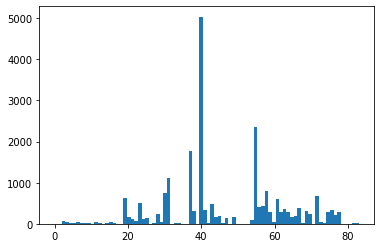

In [15]:
plt.hist(items['item_category_id'],bins=items['item_category_id'].nunique());

## Shops

In [16]:
get_descriptive_stats(shops)

SHAPE:
(60, 2)



SAMPLE:
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4



#UNIQUE:
shop_name    60
shop_id      60
dtype: int64



MISSING VALUES:
shop_name    0
shop_id      0
dtype: int64



DESCRIPTIVES:
         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000


In [17]:
shops.head(100)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


* Google tells me 'Москва' means 'Moscow', so probably the first word is the city, we can extract this as a feature.


## Item Categories

In [18]:
get_descriptive_stats(item_categories)

SHAPE:
(84, 2)



SAMPLE:
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4



#UNIQUE:
item_category_name    84
item_category_id      84
dtype: int64



MISSING VALUES:
item_category_name    0
item_category_id      0
dtype: int64



DESCRIPTIVES:
       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000


In [19]:
item_categories.head(50)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


We can extract a few things here:
* There seems to be a lot of information about the device, for example 'PC' or 'PSN'.
* There are also more broader categories hidden here, for example 'Кино' means 'film', so all categories containing 'Кино' are about film sales.

# Data Leakage

Data leakage in this case could happen if information about the test set is present in the training data. However the train and test set in this case are strictly split on time, where the training set stops in october 2015 (and we need to predict for November 2015):

In [34]:
sales_train['year_month'] = sales_train['year'].astype(str) + '-' + sales_train['month'].astype(str)
sales_train.year_month.max()

'2015-10'

However what could happen is that some of the shops are closed or some of the products are not being sold anymore, in which case the future sales of the shop/item will be 0. To estimate if this happens let's look at the last time a shop sold any item or the last time a specific item was sold. 

In [21]:
closed_shops = sales_train[sales_train.groupby('shop_id')['year_month'].transform('max')<'2015-10'].shop_id.unique()
closed_shops

array([23, 27, 29,  0,  1,  8, 13, 30, 32, 54, 43, 51, 17, 40, 33, 11])

It seems a couple of shops haven't sold anything in a few years! So they are most likely closed. However this is only directly useful if we need to predict stuff for those shops. Let's see which shops are in the test set:

In [22]:
set(test.shop_id.unique()).intersection(closed_shops)

set()

No shops are closed in the test set, so we can't use this information. How about the items?

In [44]:
closed_items = sales_train[sales_train.groupby('item_id')['year_month'].transform('max')<'2014-10'].item_id.unique()
closed_items

array([2554, 2565, 2572, ..., 5696, 5705, 6381])

In [45]:
overlap = set(test.item_id.unique()).intersection(closed_items)

We have some items that were not sold after 2014-10 but appear in the test set! I'm looking further back then in the case of shops since we can imagine every shop to have at lesat 1 sale in a month but for items it could esaily happen that some months no sales for a particular item were made. Let's say if the item hasn't been sold in a year (hence the 2014-10) it's most likely not going to be sold as well in 2015-11. Let's have a look to confirm we did it correctly.

In [47]:
for i in overlap:
    print(i)
    print(sales_train[sales_train.item_id==i].groupby('year_month').sum()[['item_cnt_day']])

   1.0
2014-02              2.0
2014-03              1.0
2014-04              1.0
9800
            item_cnt_day
year_month              
2013-01             23.0
2013-02             29.0
2013-03             29.0
2013-04             14.0
2013-05              9.0
2013-06              8.0
2013-07             12.0
2013-08             10.0
2013-09             15.0
2013-10              5.0
2013-11              5.0
2013-12              2.0
2014-01              6.0
2014-02              2.0
2014-04              2.0
2014-05              1.0
88
            item_cnt_day
year_month              
2013-01              7.0
2013-02              7.0
2013-03              4.0
2013-04              4.0
2013-05              1.0
2013-06              3.0
2013-07              4.0
2013-09              1.0
2013-10              1.0
2013-11              2.0
2013-12              4.0
2014-01              1.0
2014-02              1.0
2014-03              1.0
2014-04              1.0
2014-07              1.0
16986
    

Okay, let's predict 0 for those!

# Feature engineering

In [53]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,01,2013
1,03.01.2013,0,25,2552,899.00,1.0,01,2013
2,05.01.2013,0,25,2552,899.00,-1.0,01,2013
3,06.01.2013,0,25,2554,1709.05,1.0,01,2013
4,15.01.2013,0,25,2555,1099.00,1.0,01,2013


Given that we are trying to predict sales for a particular shop-item pair for a month, it probably makes sense to look at lagged features in this case; i.e. the sale of a particular item/shop combination is probably well predicted by the sales of the shop, item or item + shop sales in the last X months, for different values of X. The data we are given is based on daily data, since we are only interested in monthly data it makes sense to aggregate the data first on a per month basis. So to generate a set of features we do the following:

* aggregate the data by month
* add broad categories, devices and city as found by EDA above
* add last 1, 3, 6, 12 months of sales data for the shopxitem, shop, item, itemxcity, city combinations

Since I haven't used target mean encoding before and I want to learn how to do this:
* for categorical variables, we will try both one-hot encoding and mean encoding with smoothing to compare performance